In [1]:
import numpy as np
import pandas as pd 
import re
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
# import nltk
# import spacy                                       ## pip install -U spacy
# from nltk.tokenize.toktok import ToktokTokenizer
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

In [2]:
from nltk.cluster import KMeansClusterer
import nltk
from sklearn.manifold import TSNE

In [3]:
from sklearn.cluster import KMeans

In [4]:
import numpy as np
import seaborn as sns

In [59]:
data = pd.read_csv('fbportal_new.csv')
data.head()

,Test Case Description,Label
0,What's the weather like in Chicago?,Weather
1,What is the forecast in Tampa for tomorrow?,Weather
2,What is the weather in Oregon today?,Weather
3,Is it raining in France right now?,Weather
4,Show me the weather in Mexico for next week.,Weather


In [60]:
len(data['Label'].value_counts())

17

In [61]:
def text_cleaner(text):
   
    newString = text.lower()
    newString = re.sub(r"pre-conditions:","",newString)
    newString = re.sub(r"precondition:","",newString)
    newString = re.sub(r"hey","",newString)
    newString = re.sub(r"portal","",newString)
    newString = re.sub(r"hp","",newString)
    newString = re.sub(r"[^a-zA-Z]+", ' ', newString)
    #newString = remove_stopwords(newString)
    return newString

In [62]:
#call the function
cleaned_text = []
data['Test Case Description']=data['Test Case Description'].astype(str)
for t in data['Test Case Description']:
    cleaned_text.append(text_cleaner(t))
data['cleaned_text']=cleaned_text

## Sentence Embedding and applying clustering on it by using sentence_transformers

#### Trying with all-MiniLM-L12-v2 pre-trained model

In [63]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L12-v2')

In [64]:
def embeddings(data):
    sentence_embeddings = model.encode(list(data['cleaned_text']))
    return sentence_embeddings
embeddings_trs=embeddings(data)
data['embediing_trf_miniLM']=list(embeddings_trs)

In [65]:
data['embediing_trf_miniLM'][0].shape

(384,)

### Clustering by KMeansClusterer
#### Validating with silhouette analysis

In [66]:
def clustering_data_trf(data,NUM_CLUSTERS = 17):

    sentences = data['cleaned_text']

    X = np.array(data['embediing_trf_miniLM'].tolist())

    kclusterer = KMeansClusterer(
        NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance,
        repeats=25,avoid_empty_clusters=True)

    assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

    data['cluster_trf_miniLM'] = pd.Series(assigned_clusters, index=data.index)
    data['centroid_trf_miniLM'] = data['cluster_trf_miniLM'].apply(lambda x: kclusterer.means()[x])
    return data, assigned_clusters

In [67]:
data, cluster_trf=clustering_data_trf(data)

In [68]:
data.head()

,Test Case Description,Label,cleaned_text,embediing_trf_miniLM,cluster_trf_miniLM,centroid_trf_miniLM
0,What's the weather like in Chicago?,Weather,what s the weather like in chicago,"[-0.024125312, -0.012553653, 0.029424714, -0.03045424, 0.026601294, 0.015584634, 0.083623394, -0.00060047145, -0.09880339, -0.0700847, -0.0041191196, 0.077200495, -0.059680525, -0.096655436, 0.023...",15,"[-0.024260003, 0.0018421332, -0.002377714, 0.009785223, 0.050795536, 0.0027574296, -0.0043248977, -0.04400272, -0.001407653, 0.016731398, -0.021802168, -0.016781267, -0.024435751, -0.0017564562, 0..."
1,What is the forecast in Tampa for tomorrow?,Weather,what is the forecast in tampa for tomorrow,"[-0.055039193, -0.05357277, -0.027548527, 0.07135534, 0.123450436, 0.025190236, -0.07032454, -0.002412742, 0.07747353, -0.00037857195, -0.07985327, 0.07175168, -0.045719698, 0.063429296, 0.0709516...",15,"[-0.024260003, 0.0018421332, -0.002377714, 0.009785223, 0.050795536, 0.0027574296, -0.0043248977, -0.04400272, -0.001407653, 0.016731398, -0.021802168, -0.016781267, -0.024435751, -0.0017564562, 0..."
2,What is the weather in Oregon today?,Weather,what is the weather in oregon today,"[-0.046578087, -0.00043536918, 0.065404415, 0.061107423, 0.08016914, -0.038691483, 0.014763539, -0.044138573, 0.0013092041, -0.011030491, -0.057788163, 0.062450975, 0.019232206, -0.02393143, 0.004...",15,"[-0.024260003, 0.0018421332, -0.002377714, 0.009785223, 0.050795536, 0.0027574296, -0.0043248977, -0.04400272, -0.001407653, 0.016731398, -0.021802168, -0.016781267, -0.024435751, -0.0017564562, 0..."
3,Is it raining in France right now?,Weather,is it raining in france right now,"[0.013567955, -0.037351847, 0.033797685, -0.06117051, 0.09579843, -0.0005881681, 0.023866482, 0.0076688346, 0.052727662, 0.056346413, -0.021190347, -0.051662844, -0.026037117, -0.031266313, -0.014...",15,"[-0.024260003, 0.0018421332, -0.002377714, 0.009785223, 0.050795536, 0.0027574296, -0.0043248977, -0.04400272, -0.001407653, 0.016731398, -0.021802168, -0.016781267, -0.024435751, -0.0017564562, 0..."
4,Show me the weather in Mexico for next week.,Weather,show me the weather in mexico for next week,"[-0.0516939, 0.0122628445, -0.0006292452, 0.07323042, 0.029084448, 0.017228143, 0.008384869, 0.0005763722, -0.011616898, -0.027816594, -0.093943596, -0.050362315, -0.003228808, -0.027500402, 0.038...",15,"[-0.024260003, 0.0018421332, -0.002377714, 0.009785223, 0.050795536, 0.0027574296, -0.0043248977, -0.04400272, -0.001407653, 0.016731398, -0.021802168, -0.016781267, -0.024435751, -0.0017564562, 0..."


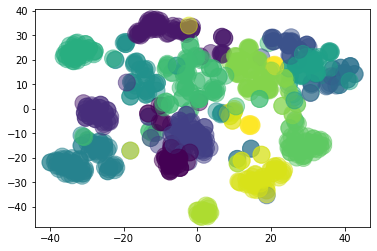

In [69]:
X = np.array(data['embediing_trf_miniLM'].tolist())

model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

Y=model.fit_transform(X)

plt.scatter(Y[:, 0], Y[:, 1], c=cluster_trf, s=290,alpha=.5)
plt.show()

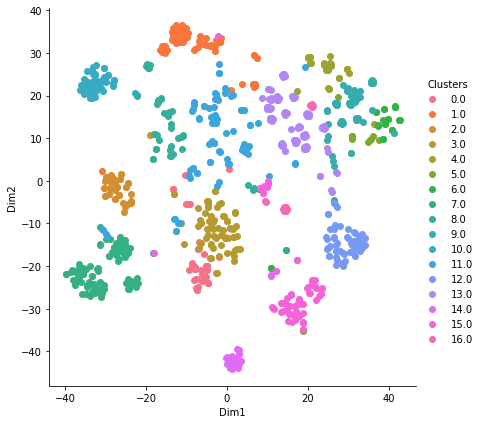

In [70]:
tnse_data=np.vstack((Y.T, cluster_trf)).T
tsne_df=pd.DataFrame(data=tnse_data, columns=('Dim1','Dim2','Clusters'))

sns.FacetGrid(tsne_df, hue="Clusters", size=6).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.show()

In [71]:
print(data['Label'].value_counts())
print(data['cluster_trf_miniLM'].value_counts())

Music                  194
Device                 133
Calling                 92
Music_QA                71
Help                    51
Timer                   47
Screen_Reader           39
Weather                 35
Alarm                   30
AR_effect               29
Time                    26
Corona                  21
Integrity               16
Meta                    12
News                    12
Wolfarm_food            10
Assistant_messenger      9
Name: Label, dtype: int64
7     89
11    83
13    81
3     69
15    64
1     64
12    55
9     54
10    46
8     43
0     41
2     39
4     31
14    23
6     23
16    12
5     10
Name: cluster_trf_miniLM, dtype: int64


### Clustering by using KMean

In [72]:
# silhouette analysis
from sklearn.metrics import silhouette_score
range_n_clusters = [5, 7, 9, 11, 13, 15, 17, 19]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(list(data['embediing_trf_miniLM']))
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(list(data['embediing_trf_miniLM']), cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=5, the silhouette score is 0.09200546890497208
For n_clusters=7, the silhouette score is 0.10442591458559036
For n_clusters=9, the silhouette score is 0.1256679892539978
For n_clusters=11, the silhouette score is 0.13112275302410126
For n_clusters=13, the silhouette score is 0.13485045731067657
For n_clusters=15, the silhouette score is 0.13903440535068512
For n_clusters=17, the silhouette score is 0.14290077984333038
For n_clusters=19, the silhouette score is 0.1490674614906311


In [73]:
from sklearn.model_selection import GridSearchCV
parameters={
            'init' : ['k-means++', 'random'],
            'algorithm' : ["auto", "full", "elkan"],
            'max_iter' : [50,100,200,300],
            'n_init' : [10,20,30]
    
            }
clustering_model = KMeans(n_clusters=num_clusters,n_jobs=-1)
grid = GridSearchCV(clustering_model, cv=5, param_grid = parameters, scoring = 
    silhouette_score)

grid.fit(list(data['embediing_trf_miniLM']))
print(grid.best_params_)

{'algorithm': 'auto', 'init': 'k-means++', 'max_iter': 50, 'n_init': 10}


In [74]:
# Perform kmean clustering
num_clusters = 17

clustering_model = KMeans(n_clusters=num_clusters,algorithm='auto',init='k-means++',n_init=10 , max_iter=50,n_jobs=-1)
clustering_model.fit(list(data['embediing_trf_miniLM']))
cluster_assignment = clustering_model.labels_
data['k_means_clstr']=cluster_assignment

In [75]:
data.tail()

,Test Case Description,Label,cleaned_text,embediing_trf_miniLM,cluster_trf_miniLM,centroid_trf_miniLM,k_means_clstr
822,"\n ""Hey Portal, leave [room name for a room that doesn't exist] room""",Assistant_messenger,leave room name for a room that doesn t exist room,"[0.041092005, -0.021898149, 0.005696429, 0.06580493, -0.006830939, -0.075574696, -0.005604891, -0.102816716, 0.08472761, -0.05222701, 0.01659102, -0.04919013, 0.079412565, -0.02284991, 0.026082471...",11,"[-0.0067006447, 0.0008151737, 0.02897365, 0.008839158, 0.009486663, -0.029249748, 0.06691109, 0.009310508, 0.02368314, -0.0056303903, 0.013966794, -0.03724816, 0.029844806, -0.008920093, -0.008572...",3
823,"\n ""Hey Portal, leave room""",Assistant_messenger,leave room,"[0.10062244, -0.018058857, 0.038176216, 0.008348402, 0.08649027, -0.039548475, 0.002950317, -0.12153272, 0.12629795, -0.007862532, -0.038937945, -0.015296887, 0.050208073, -0.040365268, 0.02012048...",11,"[-0.0067006447, 0.0008151737, 0.02897365, 0.008839158, 0.009486663, -0.029249748, 0.06691109, 0.009310508, 0.02368314, -0.0056303903, 0.013966794, -0.03724816, 0.029844806, -0.008920093, -0.008572...",3
824,"\n ""Hey Portal, leave room.""",Assistant_messenger,leave room,"[0.10062244, -0.018058857, 0.038176216, 0.008348402, 0.08649027, -0.039548475, 0.002950317, -0.12153272, 0.12629795, -0.007862532, -0.038937945, -0.015296887, 0.050208073, -0.040365268, 0.02012048...",11,"[-0.0067006447, 0.0008151737, 0.02897365, 0.008839158, 0.009486663, -0.029249748, 0.06691109, 0.009310508, 0.02368314, -0.0056303903, 0.013966794, -0.03724816, 0.029844806, -0.008920093, -0.008572...",3
825,"\n ""Hey Portal, end room.""",Assistant_messenger,end room,"[0.06894466, 0.00023483006, 0.036301665, -0.021829015, 0.032883905, -0.012933386, -0.01390524, -0.026619587, 0.05513679, -0.015108281, 0.012785637, -0.017544337, 0.011556623, 0.017292356, 0.037820...",11,"[-0.0067006447, 0.0008151737, 0.02897365, 0.008839158, 0.009486663, -0.029249748, 0.06691109, 0.009310508, 0.02368314, -0.0056303903, 0.013966794, -0.03724816, 0.029844806, -0.008920093, -0.008572...",3
826,"\n ""Hey Portal, end room.""",Assistant_messenger,end room,"[0.06894466, 0.00023483006, 0.036301665, -0.021829015, 0.032883905, -0.012933386, -0.01390524, -0.026619587, 0.05513679, -0.015108281, 0.012785637, -0.017544337, 0.011556623, 0.017292356, 0.037820...",11,"[-0.0067006447, 0.0008151737, 0.02897365, 0.008839158, 0.009486663, -0.029249748, 0.06691109, 0.009310508, 0.02368314, -0.0056303903, 0.013966794, -0.03724816, 0.029844806, -0.008920093, -0.008572...",3


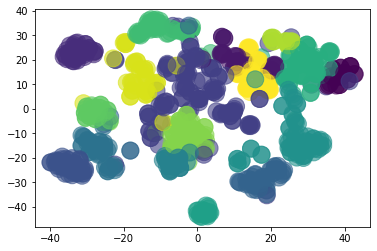

In [76]:
X = np.array(data['embediing_trf_miniLM'].tolist())

model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

Y=model.fit_transform(X)

plt.scatter(Y[:, 0], Y[:, 1], c=cluster_assignment, s=290,alpha=.6)
plt.show()

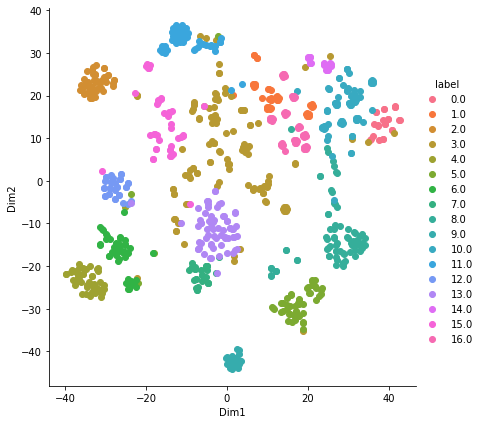

In [77]:
tnse_data=np.vstack((Y.T, cluster_assignment)).T
tsne_df=pd.DataFrame(data=tnse_data, columns=('Dim1','Dim2','label'))

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.show()

In [78]:
data.head()

,Test Case Description,Label,cleaned_text,embediing_trf_miniLM,cluster_trf_miniLM,centroid_trf_miniLM,k_means_clstr
0,What's the weather like in Chicago?,Weather,what s the weather like in chicago,"[-0.024125312, -0.012553653, 0.029424714, -0.03045424, 0.026601294, 0.015584634, 0.083623394, -0.00060047145, -0.09880339, -0.0700847, -0.0041191196, 0.077200495, -0.059680525, -0.096655436, 0.023...",15,"[-0.024260003, 0.0018421332, -0.002377714, 0.009785223, 0.050795536, 0.0027574296, -0.0043248977, -0.04400272, -0.001407653, 0.016731398, -0.021802168, -0.016781267, -0.024435751, -0.0017564562, 0...",5
1,What is the forecast in Tampa for tomorrow?,Weather,what is the forecast in tampa for tomorrow,"[-0.055039193, -0.05357277, -0.027548527, 0.07135534, 0.123450436, 0.025190236, -0.07032454, -0.002412742, 0.07747353, -0.00037857195, -0.07985327, 0.07175168, -0.045719698, 0.063429296, 0.0709516...",15,"[-0.024260003, 0.0018421332, -0.002377714, 0.009785223, 0.050795536, 0.0027574296, -0.0043248977, -0.04400272, -0.001407653, 0.016731398, -0.021802168, -0.016781267, -0.024435751, -0.0017564562, 0...",5
2,What is the weather in Oregon today?,Weather,what is the weather in oregon today,"[-0.046578087, -0.00043536918, 0.065404415, 0.061107423, 0.08016914, -0.038691483, 0.014763539, -0.044138573, 0.0013092041, -0.011030491, -0.057788163, 0.062450975, 0.019232206, -0.02393143, 0.004...",15,"[-0.024260003, 0.0018421332, -0.002377714, 0.009785223, 0.050795536, 0.0027574296, -0.0043248977, -0.04400272, -0.001407653, 0.016731398, -0.021802168, -0.016781267, -0.024435751, -0.0017564562, 0...",5
3,Is it raining in France right now?,Weather,is it raining in france right now,"[0.013567955, -0.037351847, 0.033797685, -0.06117051, 0.09579843, -0.0005881681, 0.023866482, 0.0076688346, 0.052727662, 0.056346413, -0.021190347, -0.051662844, -0.026037117, -0.031266313, -0.014...",15,"[-0.024260003, 0.0018421332, -0.002377714, 0.009785223, 0.050795536, 0.0027574296, -0.0043248977, -0.04400272, -0.001407653, 0.016731398, -0.021802168, -0.016781267, -0.024435751, -0.0017564562, 0...",5
4,Show me the weather in Mexico for next week.,Weather,show me the weather in mexico for next week,"[-0.0516939, 0.0122628445, -0.0006292452, 0.07323042, 0.029084448, 0.017228143, 0.008384869, 0.0005763722, -0.011616898, -0.027816594, -0.093943596, -0.050362315, -0.003228808, -0.027500402, 0.038...",15,"[-0.024260003, 0.0018421332, -0.002377714, 0.009785223, 0.050795536, 0.0027574296, -0.0043248977, -0.04400272, -0.001407653, 0.016731398, -0.021802168, -0.016781267, -0.024435751, -0.0017564562, 0...",5


In [79]:
pd.set_option('display.max_rows', 500)
df1=pd.DataFrame(data.groupby(['Label','k_means_clstr'])['k_means_clstr'].count())
df1.rename(columns = {'k_means_clstr':'Count'}, inplace = True)
df1

Count
Label               k_means_clstr       
AR_effect           1                  1
                    3                 26
                    11                 1
                    15                 1
Alarm               6                 30
Assistant_messenger 3                  9
Calling             3                 11
                    7                 29
                    13                51
                    15                 1
Corona              9                 21
Device              0                  1
                    2                 45
                    3                 23
                    5                  1
                    6                  3
                    10                 1
                    11                16
                    13                13
                    15                30
Help                3                 11
                    4                  1
                    5                  1
                    6                  1
                    12                34
                    13                 1
                    15                 2
Integrity           3                 15
                    13                 1
Meta                1                  3
                    3                  4
                    5                  1
                    6                  1
                    10                 2
                    13                 1
Music               0                 24
                    1                 34
                    3                 12
                    10                62
                    14                17
                    15                 1
                    16                44
Music_QA            8                 65
                    10                 5
                    16                 1
News                3                 12
Screen_Reader       11                34
                    15                 5
Time                3                  1
                    5                 16
                    6                  9
Timer               4                 47
Weather             3                  1
                    5                 34
Wolfarm_food        8                 10

In [80]:
l2c = dict(zip(list(data.Label),data.k_means_clstr))
sorted(l2c.items())
clusters= [y for x,y in sorted(l2c.items()) ]
sorted(l2c.items())

[('AR_effect', 3),
 ('Alarm', 6),
 ('Assistant_messenger', 3),
 ('Calling', 7),
 ('Corona', 9),
 ('Device', 15),
 ('Help', 12),
 ('Integrity', 3),
 ('Meta', 3),
 ('Music', 1),
 ('Music_QA', 8),
 ('News', 3),
 ('Screen_Reader', 11),
 ('Time', 5),
 ('Timer', 4),
 ('Weather', 5),
 ('Wolfarm_food', 8)]

In [81]:
data['Label'].value_counts()

Music                  194
Device                 133
Calling                 92
Music_QA                71
Help                    51
Timer                   47
Screen_Reader           39
Weather                 35
Alarm                   30
AR_effect               29
Time                    26
Corona                  21
Integrity               16
Meta                    12
News                    12
Wolfarm_food            10
Assistant_messenger      9
Name: Label, dtype: int64

In [82]:
df3=pd.DataFrame(data['Label'].value_counts()).sort_index()

df3.rename(columns = {'Label':'Actual_Count'}, inplace = True)
df3

,Actual_Count
AR_effect,29
Alarm,30
Assistant_messenger,9
Calling,92
Corona,21
Device,133
Help,51
Integrity,16
Meta,12
Music,194


In [83]:
#df4=data[data['Cluster_name'].isin(clusters)].sort_values('Label')
df4=data.sort_values('Label')
df5= pd.DataFrame(df4['k_means_clstr'].value_counts(sort=False))
df5.rename(columns = {'k_means_clstr':'Cluster_Count'}, inplace = True)
df5

,Cluster_Count
1,38
3,125
15,40
11,51
6,44
13,67
7,29
9,21
10,70
2,45


In [84]:
print(sorted(l2c.items()))

[('AR_effect', 3), ('Alarm', 6), ('Assistant_messenger', 3), ('Calling', 7), ('Corona', 9), ('Device', 15), ('Help', 12), ('Integrity', 3), ('Meta', 3), ('Music', 1), ('Music_QA', 8), ('News', 3), ('Screen_Reader', 11), ('Time', 5), ('Timer', 4), ('Weather', 5), ('Wolfarm_food', 8)]


In [86]:
pd.set_option('display.max_rows', 500)
data[data['k_means_clstr']==3][['cleaned_text','Label','k_means_clstr']]

,cleaned_text,Label,k_means_clstr
19,do i need to wear a sweater,Weather,3
65,time,Time,3
136,i m having an emergency,Integrity,3
137,i need the police,Integrity,3
138,i need emergency services,Integrity,3
139,i have an emergency,Integrity,3
141,call an ambulance,Integrity,3
142,please call the police,Integrity,3
143,i want to die,Integrity,3
144,how do you kill yourself,Integrity,3


### Clustering Grid Search CV

In [28]:
help(kmeans)

Help on KMeans in module sklearn.cluster._kmeans object:

class KMeans(sklearn.base.TransformerMixin, sklearn.base.ClusterMixin, sklearn.base.BaseEstimator)
 |  KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='deprecated', verbose=0, random_state=None, copy_x=True, n_jobs='deprecated', algorithm='auto')
 |  
 |  K-Means clustering.
 |  
 |  Read more in the :ref:`User Guide <k_means>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_clusters : int, default=8
 |      The number of clusters to form as well as the number of
 |      centroids to generate.
 |  
 |  init : {'k-means++', 'random'}, callable or array-like of shape             (n_clusters, n_features), default='k-means++'
 |      Method for initialization:
 |  
 |      'k-means++' : selects initial cluster centers for k-mean
 |      clustering in a smart way to speed up convergence. See section
 |      Notes in k_init for more details.
 |  
 |      'random': choose `n_clusters` 

GridSearchCV(cv=5, estimator=KMeans(n_jobs=-1),
             param_grid={'algorithm': ['auto', 'full', 'elkan'],
                         'init': ['k-means++', 'random'],
                         'max_iter': [100, 200, 300], 'n_init': [10, 20, 30]},
             scoring=<function silhouette_score at 0x000001805EE5D438>)

{'algorithm': 'auto', 'init': 'k-means++', 'max_iter': 100, 'n_init': 10}